In [60]:
from metrics import *

In [85]:
exp = "final"
data_path = f'../data/{exp}/data/'
results_path = f'../data/{exp}/results/'
# Define  length of test data
n_test = 250

In [86]:
# Prepare dataframe
models = ["brown", "powexp"]
metrics = ["MSE_r", "MSE_s", "MSE_ext", "IS_r", "IS_s", "IIS", "KL", "ES"]
results = pd.DataFrame("-", index = pd.MultiIndex.from_product([models, metrics]), columns = ["PL", "CNN", "ABC", "CNN_ES"])
results

PL CNN ABC CNN_ES
brown  MSE_r    -   -   -      -
       MSE_s    -   -   -      -
       MSE_ext  -   -   -      -
       IS_r     -   -   -      -
       IS_s     -   -   -      -
       IIS      -   -   -      -
       KL       -   -   -      -
       ES       -   -   -      -
powexp MSE_r    -   -   -      -
       MSE_s    -   -   -      -
       MSE_ext  -   -   -      -
       IS_r     -   -   -      -
       IS_s     -   -   -      -
       IIS      -   -   -      -
       KL       -   -   -      -
       ES       -   -   -      -

## Compare Metrics

In [87]:
def fill_metrics(results, model, true_parameters, pl, abc, cnn, cnn_es, alpha = 0.05):
    #Get mean prediction
    abc_mean = np.mean(abc, axis = 2)
    cnn_es_mean = np.mean(cnn_es, axis = 2)
    # PL
    results.loc[(model, ["MSE_r", "MSE_s"]), "PL"] = get_mse(true_parameters, pl)
    results.loc[(model, "MSE_ext"), "PL"] = get_integrated_error(model, true = true_parameters, estimate = pl)

    # CNN 
    results.loc[(model, ["MSE_r", "MSE_s"]), "CNN"] = get_mse(true_parameters, cnn)
    results.loc[(model, "MSE_ext"), "CNN"] = get_integrated_error(model, true = true_parameters, estimate = cnn)

    # ABC
    results.loc[(model, ["MSE_r", "MSE_s"]), "ABC"] = get_mse(true_parameters, abc_mean)
    results.loc[(model, "MSE_ext"), "ABC"] = get_integrated_error(model, true = true_parameters, estimate = abc, method = "sample")

    quantiles = np.quantile(abc, [alpha/2,1-(alpha/2)], axis = 2)
    results.loc[(model, ["IS_r", "IS_s"]), "ABC"] = get_interval_score(true_parameters, alpha = alpha, q_left = quantiles[0], q_right = quantiles[1])

    results.loc[(model, ["ES"]), "ABC"] = get_energy_score(true_parameters,abc)

    # CNN ES
    results.loc[(model, ["MSE_r", "MSE_s"]), "CNN_ES"] = get_mse(true_parameters, cnn_es_mean)
    results.loc[(model, "MSE_ext"), "CNN_ES"] = get_integrated_error(model, true = true_parameters, estimate = cnn_es, method = "sample")

    quantiles = np.quantile(cnn_es, [alpha/2,1-(alpha/2)], axis = 2)
    results.loc[(model, ["IS_r", "IS_s"]), "CNN_ES"] = get_interval_score(true_parameters, alpha = alpha, q_left = quantiles[0], q_right = quantiles[1])

    results.loc[(model, ["ES"]), "CNN_ES"] = get_energy_score(true_parameters, cnn_es)
    return results


In [88]:
for model in models:
    # Load true parameters
    true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
    # Load PL
    pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
    # Load ABC
    abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
    # Load normal network
    cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

    # Load energy network
    cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]
    
    results = fill_metrics(results, model, true_parameters, pl, abc, cnn, cnn_es)

c:\Users\chris\Desktop\Masterarbeit\code\evaluation\metrics.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  res = np.exp(-np.power((h / r), s))


In [89]:
results

PL       CNN       ABC    CNN_ES
brown  MSE_r     3.18932  0.472544  1.614511  0.508282
       MSE_s    0.125622  0.024802  0.255105   0.03339
       MSE_ext  0.453791  0.141909  0.907181  0.185404
       IS_r            -         -   4.58771  3.497198
       IS_s            -         -  3.434002  1.167885
       IIS             -         -         -         -
       KL              -         -         -         -
       ES              -         -  0.849177  0.400728
powexp MSE_r    8.350374  0.665863  1.595643  0.502649
       MSE_s    0.776954  0.110913  0.186402  0.183514
       MSE_ext  0.104127  0.009199  0.016567  0.009346
       IS_r            -         -  4.296605  4.464101
       IS_s            -         -  1.466165   1.68099
       IIS             -         -         -         -
       KL              -         -         -         -
       ES              -         -  0.815351  0.510007

In [70]:
print(results.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.4f}".format,
))  

\begin{tabular}{llllll}
\toprule
 &  & PL & CNN & ABC & CNN_ES \\
\midrule
\multirow[t]{8}{*}{brown} & MSE_r & 3.189320 & 0.472544 & 1.614511 & 0.508282 \\
 & MSE_s & 0.125622 & 0.024802 & 0.255105 & 0.033390 \\
 & MSE_ext & 0.453791 & 0.141909 & 0.907181 & 0.185404 \\
 & IS_r & - & - & 4.587710 & 3.497198 \\
 & IS_s & - & - & 3.434002 & 1.167885 \\
 & IIS & - & - & - & - \\
 & KL & - & - & - & - \\
 & ES & - & - & 0.849177 & 0.400728 \\
\cline{1-6}
\multirow[t]{8}{*}{powexp} & MSE_r & 8.350374 & 0.665863 & 1.595643 & 0.502649 \\
 & MSE_s & 0.776954 & 0.110913 & 0.186402 & 0.183514 \\
 & MSE_ext & 0.104127 & 0.009199 & 0.016567 & 0.009346 \\
 & IS_r & - & - & 4.296605 & 4.464101 \\
 & IS_s & - & - & 1.466165 & 1.680990 \\
 & IIS & - & - & - & - \\
 & KL & - & - & - & - \\
 & ES & - & - & 0.815351 & 0.510007 \\
\cline{1-6}
\bottomrule
\end{tabular}



## Graphical evaluation

In [110]:
#Load examples
model = "powexp"

# Load true parameters
true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
# Load PL
pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
# Load ABC
abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
# Load normal network
cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

# Load energy network
cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]

#Get mean prediction
abc_mean = np.mean(abc, axis = 2)
cnn_es_mean = np.mean(cnn_es, axis = 2)

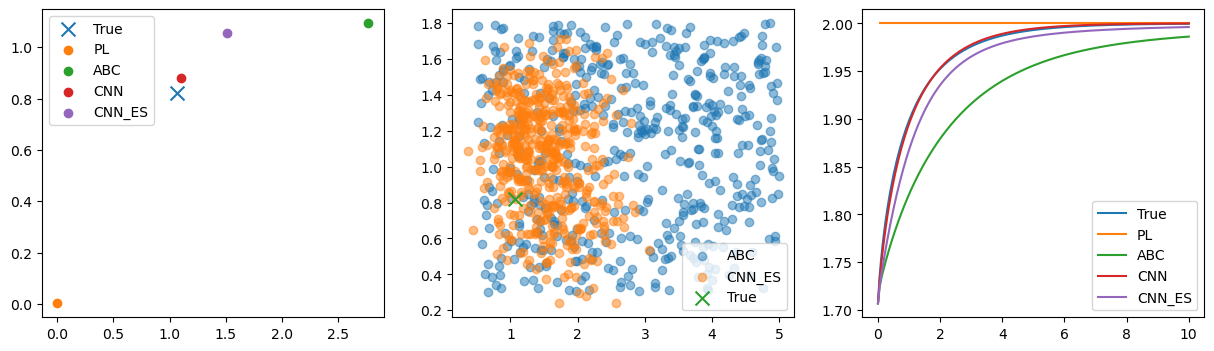

In [122]:
sample = np.random.randint(0, n_test)

h = np.linspace(0,np.sqrt(10**2),200)
fig, axs = plt.subplots(1, 3, figsize = (15,4))

#Mean values
axs[0].scatter(x = true_parameters[sample,0], y = true_parameters[sample,1], marker = "x", s = 100)
axs[0].scatter(x = pl[sample,0], y = pl[sample,1])
axs[0].scatter(x = abc_mean[sample,0], y = abc_mean[sample,1])
axs[0].scatter(x = cnn[sample,0], y = cnn[sample,1])
axs[0].scatter(x = cnn_es_mean[sample,0], y = cnn_es_mean[sample,1])
axs[0].legend(["True", "PL", "ABC", "CNN", "CNN_ES"])

# Sample values
axs[1].scatter(x = abc[sample,0], y = abc[sample,1], alpha = 0.5)
axs[1].scatter(x = cnn_es[sample,0], y = cnn_es[sample,1], alpha = 0.5)
axs[1].scatter(x = true_parameters[sample,0], y = true_parameters[sample,1], marker = "x", s = 100)
axs[1].legend(["ABC", "CNN_ES", "True"])

# Extremal coefficient
axs[2].plot(h, extremal_coefficient(h, model, true_parameters[sample,0], true_parameters[sample,1]))
axs[2].plot(h, extremal_coefficient(h, model, pl[sample,0], pl[sample,1]))
axs[2].plot(h, sample_extremal_coefficient(h, model, abc[sample,0], abc[sample,1]))
axs[2].plot(h, extremal_coefficient(h, model, cnn[sample,0], cnn[sample,1]))
axs[2].plot(h, sample_extremal_coefficient(h, model, cnn_es[sample,0], cnn_es[sample,1]))

axs[2].legend(["True", "PL", "ABC", "CNN", "CNN_ES"])


In [8]:
abc[0,sample].shape

(500,)